In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
train = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k", 1.0),
    (5, "l m n", 0.0),
    (6, "spark hadoop spark", 1.0),
    (7, "apache hadoop", 1.0)
], ["id", "text", "label"])

In [0]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
  ColSpec("long", "id"),
  ColSpec("string", "text"),
  ColSpec("double", "label"),
])
output_schema = Schema([ColSpec("double")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [0]:
import mlflow

lr_maxIter = 10
lr_regParam = 0.001

with mlflow.start_run(run_name="New ideas") as run:
    mlflow.log_param("lr_maxIter", lr_maxIter)
    mlflow.log_param("lr_regParam", lr_regParam) 
    # Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
    lr = LogisticRegression(maxIter=lr_maxIter, regParam=lr_regParam)
    pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])
    # Fit the pipeline to training documents.
    model = pipeline.fit(train)
    
    # log the model with the signature
    mlflow.spark.log_model(model, 'lr_model', signature=signature)
    mlflow.log_dict({"key": "value"}, "files/data.txt")
    prediction = model.transform(test)
    
    evaluator = BinaryClassificationEvaluator(labelCol='label')
    perf = evaluator.evaluate(prediction)
    print("Estimator performance: {:.4f}".format(perf))
    
    auroc = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})
    auprc = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderPR"})
    print("Area under ROC Curve: {:.4f}".format(auroc))
    print("Area under PR Curve: {:.4f}".format(auprc))
    
    mlflow.log_metric("performace", perf)
    mlflow.log_metric("areaUnderROC", auroc)
    mlflow.log_metric("areaUnderPR", auprc)
    

Estimator performance: 0.6667
Area under ROC Curve: 0.6667
Area under PR Curve: 0.9028

In [0]:
selected = prediction.select("id", "text", "probability", "label", "prediction")
for row in selected.collect():
    rid, text, prob, label, pred = row  # type: ignore
    print(
        "(%d, %s) --> prob=%s, label=%f, prediction=%f" % (
            rid, text, str(prob), label, pred   # type: ignore
        )
    )

(4, spark i j k) --> prob=[0.6292098489668488,0.37079015103315116], label=1.000000, prediction=0.000000
(5, l m n) --> prob=[0.9847700067623042,0.015229993237695805], label=0.000000, prediction=0.000000
(6, spark hadoop spark) --> prob=[0.13412348342566116,0.8658765165743388], label=1.000000, prediction=1.000000
(7, apache hadoop) --> prob=[0.9955732114398529,0.00442678856014711], label=1.000000, prediction=0.000000

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(

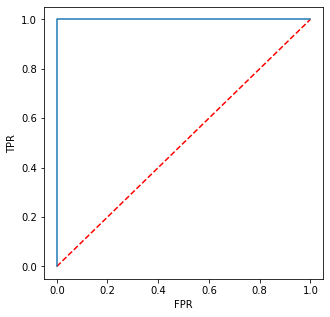

In [0]:
# (receiver operating characteristic curve)
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.stages[-1].summary.roc.select('FPR').collect(),
         model.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [0]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

Out[65]:

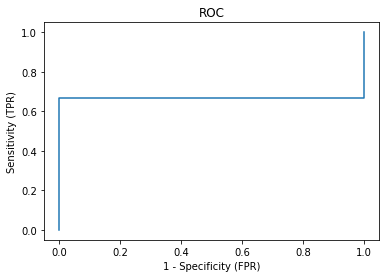

[<matplotlib.lines.Line2D at 0x7f2b2c8a0fd0>]

In [0]:
import matplotlib.pyplot as plt

# Returns as a list (false positive rate, true positive rate)
preds = prediction.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC')
plt.xlabel('1 - Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.plot(x_val, y_val)